# Part1. Fashon-MNIST图像分类数据集

In [198]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

## 读取数据集

In [199]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0到1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [200]:
len(mnist_train),len(mnist_test)

(60000, 10000)

In [201]:
mnist_train[6000][0].shape

torch.Size([1, 28, 28])

In [202]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [203]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    figure = plt.figure(figsize=figsize)

    for i, img in enumerate(imgs):
        figure.add_subplot(num_rows,num_cols,i+1)
        if torch.is_tensor(img):
            # 图片张量
            plt.imshow(img.numpy(),cmap="gray")
        else:
            # PIL图片
            plt.imshow(img,cmap="gray")
        plt.axis("off")
        if titles:
            plt.title(titles[i])
    return plt

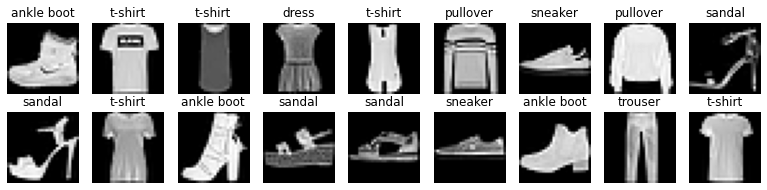

In [204]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 读取小批量

In [205]:
batch_size = 256

def get_dataloader_workers():  #@save
    """使用4个进程来读取数据"""
    return 20

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [206]:
import time

t0 = time.time()
for X,y in train_iter:
    continue
t1 = time.time()

print(t1-t0)

0.6646575927734375


## 整合所有组件为函数

In [207]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [208]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


# Part2. softmax回归从零实现

In [209]:
import torch
from IPython import display

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [210]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

## 定义softmax操作

In [211]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [212]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp / partition

In [213]:
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0617, 0.1765, 0.1849, 0.4186, 0.1583],
         [0.1051, 0.0418, 0.1154, 0.4251, 0.3127]]),
 tensor([1., 1.]))

## 定义模型

In [214]:
def net(X):
    return softmax(X.reshape(-1,W.shape[0]) @ W + b)

## 定义损失函数

In [215]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [216]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)),y])

cross_entropy(y_hat,y)

tensor([2.3026, 0.6931])

## 计算精度

In [217]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [218]:
accuracy(y_hat,y) / len(y)

0.5

In [219]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [220]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [221]:
evaluate_accuracy(net,test_iter)

0.121

## 训练

In [222]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

## 动画绘制数据程序类（略）

In [223]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

## 最终训练次数+可视化+评估

In [224]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
         
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}\n-------------")
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print(f"Train Loss: {train_metrics[0]}\n")
        print(f"Train Acc: {train_metrics[1]}\n")
        print(f"Test Acc: {test_acc}\n")
        
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

## 定义优化算法

In [225]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [226]:
def updater(batch_size):
    return sgd([W,b], lr, batch_size)

## 训练开始

In [227]:
lr = 0.5
num_epochs = 10
train_ch3(net,train_iter,test_iter,cross_entropy,num_epochs,updater)

Epoch 1
-------------
Train Loss: 1.6314511578877766

Train Acc: 0.7148666666666667

Test Acc: 0.733

Epoch 2
-------------
Train Loss: 0.9814538647969564

Train Acc: 0.7884166666666667

Test Acc: 0.7306

Epoch 3
-------------
Train Loss: 0.9091545701344808

Train Acc: 0.8000666666666667

Test Acc: 0.7835

Epoch 4
-------------
Train Loss: 0.8594725912729899

Train Acc: 0.80665

Test Acc: 0.7798

Epoch 5
-------------
Train Loss: 0.81696922082901

Train Acc: 0.8102833333333334

Test Acc: 0.8096

Epoch 6
-------------
Train Loss: 0.8683869676589966

Train Acc: 0.8076

Test Acc: 0.834

Epoch 7
-------------
Train Loss: 0.7975467556635538

Train Acc: 0.8163666666666667

Test Acc: 0.8299

Epoch 8
-------------
Train Loss: 0.7842288515090943

Train Acc: 0.8165166666666667

Test Acc: 0.8118

Epoch 9
-------------
Train Loss: 0.7502091416041057

Train Acc: 0.82075

Test Acc: 0.7882

Epoch 10
-------------
Train Loss: 0.7745540547688802

Train Acc: 0.82025

Test Acc: 0.7876



AssertionError: 0.7745540547688802

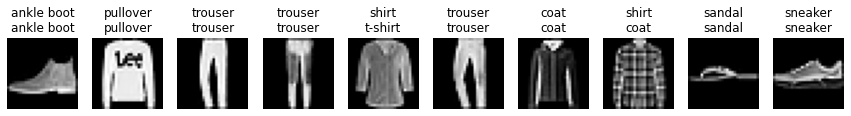

In [230]:
def predict_ch3(net, test_iter, n=10):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

# Part3. softmax回归简洁实现

In [231]:
import torch
from torch import nn

batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化参数模型

In [232]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

## softmax实现
### 为了防止数值溢出，且softmax取指数，交叉熵损失函数取对数，所以直接将softmax和交叉熵结合到一起作损失函数，既解决了数值稳定性的问题又减少了冗余计算

In [233]:
loss = nn.CrossEntropyLoss(reduction='none')

## 优化器

In [234]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

In [235]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

Epoch 1
-------------
Train Loss: 0.7831788724263509

Train Acc: 0.75145

Test Acc: 0.7936

Epoch 2
-------------
Train Loss: 0.5696055966695149

Train Acc: 0.8127333333333333

Test Acc: 0.8103

Epoch 3
-------------
Train Loss: 0.5247757328033448

Train Acc: 0.8255833333333333

Test Acc: 0.8149

Epoch 4
-------------
Train Loss: 0.5005068031946818

Train Acc: 0.8318333333333333

Test Acc: 0.8247

Epoch 5
-------------
Train Loss: 0.4848232748031616

Train Acc: 0.8378333333333333

Test Acc: 0.8233

Epoch 6
-------------
Train Loss: 0.4730462479909261

Train Acc: 0.8407333333333333

Test Acc: 0.8273

Epoch 7
-------------
Train Loss: 0.46629418379465737

Train Acc: 0.8420166666666666

Test Acc: 0.8249

Epoch 8
-------------
Train Loss: 0.4586968905131022

Train Acc: 0.8439166666666666

Test Acc: 0.8335

Epoch 9
-------------
Train Loss: 0.4518555862426758

Train Acc: 0.8468833333333333

Test Acc: 0.8256

Epoch 10
-------------
Train Loss: 0.44703639539082846

Train Acc: 0.84753333333333